
# **Ayoub Abraich**
## M2 Data Science 
## Paris Saclay university 

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


In [0]:
corona = pd.read_csv("cornew.csv") 

In [0]:
def get_data(pays):
  pays_data=corona[corona["Pays"]==pays].set_index('Date').drop(columns=['Pays'])
  infections=np.array(pays_data.reset_index()['Infections'])
  infections.sort()
  ###
  deces=np.array(pays_data.reset_index()['Deces'])
  deces.sort()
  return infections,deces

def plot(data,label,pays):
  plt.plot(data)
  plt.title("Evolutions des "+label+" en "+pays)
  plt.xlabel("Jours")
  plt.ylabel("Nombres des "+label)
  plt.show()

GLM

In [0]:
def GLM(data,Nday):
    n=len(data)
    X=np.arange(1,n+1)
    y=data
    X= sm.add_constant(X, prepend=False)
    model = sm.GLM(y,X,family=sm.families.Gaussian(sm.families.links.log))
    res = model.fit()
    X_test=sm.add_constant(np.arange(1,Nday+1), prepend=False) 
    y_pred = res.predict(X_test).astype(int)
    error=np.sqrt(sum((y-y_pred[0:len(data)])**2))
    print('Real data = ',y)
    print('Prediction = ',y_pred[len(y):])
    print("Erreur = ",error)
    plt.xlabel("Jours")
    plt.ylabel("Nombres des cas au Maroc")
    plt.plot(X,y,'x')
    plt.plot(np.arange(1,Nday+1),y_pred)
    plt.show()

In [0]:
def GLM_aux(pays):
        infections,deces=get_data(pays)
        print("*"*105)
        print(pays,": \n")
        print("death :\n ")
        GLM(deces,len(deces)+4)
        print("infections :\n")
        GLM(infections,len(infections)+4)
        print("*"*105)


In [0]:
p_list1=['Maroc','Algérie','Turquie']
p_list2=['France','Espagne','Italie']

*********************************************************************************************************
Maroc : 

death :
 
Real data =  [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
Prediction =  [1 1 2 2]
Erreur =  2.23606797749979


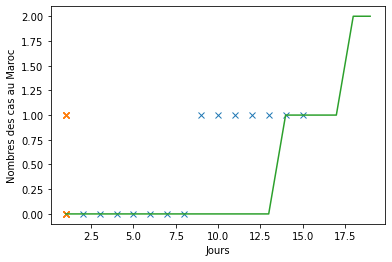

infections :

Real data =  [ 1  1  1  2  2  2  2  2  3  5  6  7 17 28 29]
Prediction =  [ 45  65  93 134]
Erreur =  8.18535277187245


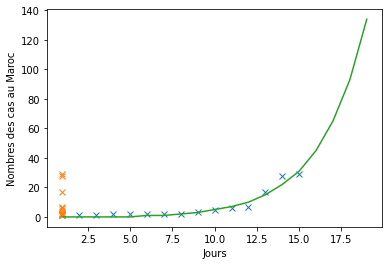

*********************************************************************************************************
*********************************************************************************************************
Algérie : 

death :
 
Real data =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4 4]
Prediction =  [ 6  9 13 19]
Erreur =  1.7320508075688772


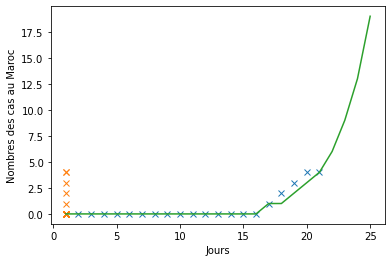

infections :

Real data =  [ 1  1  1  1  1  1  3  5 12 12 17 17 19 20 20 20 24 26 37 48 54]
Prediction =  [61 71 84 98]
Erreur =  15.811388300841896


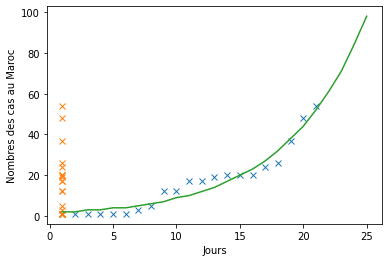

*********************************************************************************************************
*********************************************************************************************************
Turquie : 

death :
 


ValueError: ignored

In [257]:
for pays in p_list1 :
     GLM_aux(pays)

# Modelisation :

Soit $N(t)$ le nombre de cas contaminés au temps t. On a la formule récurrente (simpliste) suivante qui décrit la dynamique du propagation de l'épidimie :  
$$ N_{n+1}=N_n+ E\cdot p\cdot N_n$$ 
avec : 
  - $p$ : la probabilité que le malade contamine ceux qui sont en contact avec lui , elle est liée fortement par exmemple aux gestes barrières adoptées par les gens.
  - $E$ : la moyenne des gens qui sont en contact avec le malade contaminé . 

Dans un premier temps , on considère $E$ et $p$ contstants par rapport au temps ( ce qui est faux ! ) mais cela va nous permettre d'avoir une idée sur la dynamique de COVID19.  On obtient : 
$$N_{n+1}=N_n+ E\cdot p\cdot N_n \Leftrightarrow N_n = (1+E\cdot p)^n N_0=(1+E\cdot p)^{n-n_0}N_{n_0}$$

In [0]:
def N1(n,E,p,data):
   return (1+E*p)**n * data[0]

In [0]:
# Example 1  
E=1.
p=0.1
plt.plot([N1(i,E,p,infections) for i in range(len(infections))])

In [0]:
# Example 2
E=1.
p=0.5
plt.plot([N1(i,E,p,infections) for i in range(len(infections))])

In [0]:
# Example 3
E=2.
p=0.1
plt.plot([N1(i,E,p,infections) for i in range(len(infections))])

In [0]:
# Example 4
E=2.
p=0.5
plt.plot([N1(i,E,p,infections) for i in range(len(infections))])

In [0]:
Ep=[(0.1,0.5),(2,0.2),(5,0.1),(10,0.1),(100,0.8)]
for e in Ep :
  print("%.2e"%int(N1(50,e[0],e[1],infections)))

|  E  |  p  |   N_10   |   N_50   |
|:---:|:---:|:--------:|:--------:|
| 0.1 | 0.5 |     3    |    22    |
|  2  | 0.2 | 5.70e+01 | 4.05e+07 |
|  5  | 0.1 | 1.15e+02 | 1.28e+09 |
|  10 | 0.6 | 2.05e+03 | 2.25e+15 |
| 100 | 0.8 | 2.43e+19 | 5.31e+95 |

On constate que $E$ et $p$ determine la vitesse de propagation , ce qui justifie les mesures prises par le gouvernements ( interdiction de rassemblement afin de diminuer $E$ )  et les gestes barrieres ( afin de diminuer $p$ ) . 

Dans notre modèle simpliste , on avait oublié ( mis à part la dépendance avec le temps de $E$ et $p$ ) le fait que $p$ est décroissante dans le temps et tend vers 0 : en effet, plus le virus est propagé , la probabilité de le transmettre à quelqu'un qui est déja contaminé est quasiment nulle . Donc, on doit prendre cela en compte , on posant : 
$$ p(t):=1 - \frac{N(t)}{n_{pop}}$$ 
avec $n_{pop}$ le nombre de population dans le cluster étudié ou plus géneralement dans tout le pays . 
Cela implique une nouvelle équation différentielle simple (en supposant toujours que $E$ est indépedant du temps $t$ , ce qui faux en géneral mais pratique ) : 


$$N_{n+1}-N_n = E\cdot p\cdot N_n\rightarrow  N^{\prime}(t)=E\cdot \left ( 1-\frac{N(t)}{n_{pop}}\right )N(t)$$
et $N(t_0)=N_0$ 

On peut écrire cette EDS comme : 
$$ N^{\prime}(t)= g(t,N(t))$$
avec $g(t,y):= E\cdot (1-\frac{y}{n_{pop}})y$ et $g$ vérifie bien les condition du théoreme de Cauchy-Lipschitz : D'ou l'existence et l'unicité de la solution.

On exhibe la solution sous forme d'une logistique, cad: 
$$ N(t)=\frac{a}{\alpha+b\cdot \exp(c\cdot t)} $$




On retrouve par un simple calcul :
$$N(t)=\frac{n_{pop}}{\alpha+\gamma _0\cdot \exp(E\cdot (t_0-t))}$$
avec $\gamma_0:=\frac{n_{pop}}{N(t_0)}-\alpha$



De meme pour $p$ : 
$$p(t):=1-\frac{N(t)}{n_{pop}}=1-\frac{1}{\alpha+\gamma _0\cdot \exp(E\cdot (t_0-t))}$$

In [0]:

infections[0]

In [0]:
def N2(t,t0,E,npop,alpha,data):
  gamma0=npop/data[3]-alpha
  return npop/(alpha+gamma0*np.exp(E*(t0-t)))

In [0]:
# Examples
npop=6*10**7
t0=0
alpha=5000
E_list=[0.1,0.2,0.5,1,2,5]
for E in E_list : 
  plt.plot([N2(i,t0,E,npop,alpha,infections) for i in range(3*len(infections))],label="for E = "+str(E))

plt.title("Evolution of infections")
plt.xlabel("Days")
plt.ylabel("Number of infections")
plt.legend()
plt.show()

Rappeleons que  : $$N(t)=\frac{a}{\alpha+b\cdot \exp(c\cdot t)}=\frac{\tilde{a}}{1+\exp(-\tilde{c}\cdot(t-\tilde{b}))}$$ 
Le but maintenant est de trouver les parametres $\tilde{a},\tilde{b}$ et $\tilde{c}$ pour nos données réelles . 
On note : $$\psi_t(\theta):=\frac{\theta_1}{1+\exp(-\theta_3\cdot(t-\theta_2))}$$
On doit calculer $\theta^*:=\left (\theta_0^*,\theta_1^*,\theta_2^*\right )$ tq $$ \theta^*= \textit{argmin}_{\theta} \sum_{i=1}^{n}\left | X_{t_i}-\psi_{t_i}(\theta) \right |^{2}$$
avec la méthode Gradient Descent par exemple . Ensuite on définit notre prédicteur de $N(t)$ par : 
$$\hat{N}(t):=\psi_t(\theta^*)$$

In [0]:
from scipy import optimize

def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 500 random data sets are generated and fitted
    ps = []
    for i in range(200):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                             full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 2. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap 

def sigmoid(x, pars):
    c = pars[0]
    a = pars[1]
    b = pars[2]
    return a / (1 + np.exp(-(x-b)*c))

In [0]:
def extrapolation(data,pays,title):
        pstart = [2.43758048e-01, 4.31177862e+04, 1.95312145e+01]

        ydata = data

        xdata = np.arange(len(ydata))
                  
        pfit, perr = fit_bootstrap(pstart, xdata, ydata, sigmoid)
        fig = plt.figure(figsize=(14, 7))
        ax = fig.add_subplot(111)
        # data réelle 
        ax.plot(xdata, ydata, '+', markersize=20,label="Real infections")
        # 
        ysim = sigmoid(xdata, pfit).astype(int)
        ax.plot(xdata, ysim, '--', c = 'r')

        # Extrapolation
        xsim = np.linspace (len(xdata), 2*len(xdata))
        ysim = sigmoid(xsim, pfit).astype(int)
        ax.plot(xsim, ysim, '--', c = 'r', label="Extrapolation")


        # l'Extrapolation maximale
        ysim_sup = sigmoid(xsim, pfit+perr)
        ax.plot(xsim, ysim_sup, '--', c = 'r', alpha = 0.2)

        # l'Extrapolation minimale

        ysim_inf = sigmoid(xsim, pfit-perr)
        ax.plot(xsim, ysim_inf, '--', c = 'r', alpha = 0.2)
        plt.fill_between(xsim, ysim_sup, ysim_inf, facecolor="red", alpha=0.1)
        attesi_inf = int(ysim_inf[-1])
        attesi_sup = int(ysim_sup[-1])

        plt.title("Total final number of "+title+" expected in "+pays+f": \n between {attesi_inf} et {attesi_sup} ", size=20)
        plt.legend()
        #print(data,ysim)

In [0]:
def prediction(pays):
       infection,deces=get_data(pays)
       extrapolation(infection,pays,'infections')
       extrapolation(deces,pays,'death')
  


In [0]:
for pays in p_list2 : 
        prediction(pays)